In [1]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
import pandas as pd 
import pydot
import graphviz
import numpy as np 
import seaborn as sns
import random 
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split, KFold
from sklearn import preprocessing

tfku= tf.keras.utils
tfk = tf.keras
tfkl = tf.keras.layers

Num GPUs Available:  1


In [2]:
BATCH_SIZE = 32
SHAPE = (4096, 23)
BLOCK_SHAPE = (64, 23)
EPOCHS = 30
VARIABLES = 23
NFOLD = 5 
STEPS_PER_EPOCH = 200
ID = 28

In [3]:
if ID == 28:
    file='D:/Document/DSCI-601/NGAFID/NGAFID_MC_C28.csv'
elif ID == 37:
    file='D:/Document/DSCI-601/NGAFID/NGAFID_MC_C37.csv'
else:
    print('Invalid ID')
df_test = pd.read_csv(file, nrows=100)
float_cols = [c for c in df_test if df_test[c].dtype == "float64"]
float32_cols = {c: np.float16 for c in float_cols}

df = pd.read_csv(file, dtype=float32_cols, engine='c')
df['id'] = df.id.astype('int32')
df = df.dropna()

In [4]:
sources = df[['id', 'plane_id', 'split', 'date_diff', 'before_after']].drop_duplicates()
sources.loc[: , ['split', 'before_after', 'id']].groupby(['split', 'before_after']).count()

id
split before_after     
0     0             589
      1             484
1     0             555
      1             449
2     0             641
      1             552
3     0             343
      1             282
4     0             456
      1             382

In [5]:
input_columns = ['volt1',
 'volt2',
 'amp1',
 'amp2',
 'FQtyL',
 'FQtyR',
 'E1 FFlow',
 'E1 OilT',
 'E1 OilP',
 'E1 RPM',
 'E1 CHT1',
 'E1 CHT2',
 'E1 CHT3',
 'E1 CHT4',
 'E1 EGT1',
 'E1 EGT2',
 'E1 EGT3',
 'E1 EGT4',
 'OAT',
 'IAS',
 'VSpd',
 'NormAc',
 'AltMSL']

In [6]:
preprocess = preprocessing.MinMaxScaler()
preprocess.fit(df.loc[:, input_columns].sample(100000, random_state = 0 ))
org_value = df.loc[:, input_columns].values
res = preprocess.transform(org_value)
for i, col in enumerate(input_columns):
    df.loc[:, col] = res[:, i]

D:\Python-Anaconda\envs\tf\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


In [7]:
def get_dataset(df): 

    ids = df.id.unique()

    sensor_datas = []
    afters = [] 

    for id in ids: 
        sensor_data = df[df.id == id].iloc[-SHAPE[0]:, :23].values

        sensor_data = np.pad(sensor_data, [[0, SHAPE[0]- len(sensor_data)], [0,0]])

        sensor_data = tf.convert_to_tensor(sensor_data, dtype = tf.float32) 

        after = df[df.id == id]['before_after'].iloc[0]

        sensor_datas.append(sensor_data)
        afters.append(after)


    sensor_datas = tf.stack(sensor_datas)
    afters = np.stack(afters)

    ds = tf.data.Dataset.from_tensor_slices( (sensor_datas, afters))
    
    return ds

In [8]:
def slice_random(x, y):
    start = tf.random.uniform(shape=[], minval=0, maxval=4096-BLOCK_SHAPE[0], dtype=tf.int64)
    x = x[start: start + BLOCK_SHAPE[0]]
    x = tf.reshape(x, (BLOCK_SHAPE))
    return x, y 

In [9]:
def shift_random(x, y):
    x = tf.pad(x, [[64, 64], [0,0]])    
    start = tf.random.uniform(shape=[], minval=0, maxval=64, dtype=tf.int64)
    x = x[start: start + SHAPE[0]]
    x = tf.reshape(x, (SHAPE[0], 23))
    return x, y

In [10]:
def fix_type(x, y):

    return tf.cast(x, tf.float32), tf.cast(y, tf.float32)

In [11]:
def prepare_for_training(ds, shuffle = False, repeat = False, predict= True):
    
    ds = ds.map(fix_type)
    ds = ds.map(slice_random)

    ds = ds.shuffle(512) if shuffle else ds 
    ds = ds.repeat() if repeat else ds 
    ds = ds.batch(BATCH_SIZE, drop_remainder=True)

    if not predict: 
        ds = ds.map(lambda x, y : (x, x) ) 
    else: 
        ds = ds.map(lambda x, y : (x, tf.reshape(y, (-1, 1))) )
         
    return ds

In [12]:
def get_train_and_val_for_fold(folded_datasets, fold):
    predict = True

    train = []
    for i in range(NFOLD-1): 
        if i == fold:
            val_ds = folded_datasets[i][0].concatenate(folded_datasets[i][1])
        else: 
            train.append(folded_datasets[i][0])
    
    test_ds = folded_datasets[4][0].concatenate(folded_datasets[4][1])
    
    train_ds = None
    for ds in train: 
        train_ds = ds if train_ds is None else train_ds.concatenate(ds)

    test_ds = prepare_for_training(test_ds, shuffle=False)
    train_ds = prepare_for_training(train_ds, shuffle=True, repeat = True)
    val_ds = prepare_for_training(val_ds, shuffle=False)
    
    return train_ds, val_ds, test_ds

In [13]:
folded_datasets = []

for i in range(NFOLD):
    after = get_dataset(df[(df.split == i) & (df.before_after == 1)])
    before = get_dataset(df[(df.split == i) & (df.before_after == 0)])
    folded_datasets.append((after, before))

In [23]:
def LSTM():
    model = tfk.Sequential([
        tfk.Input(shape=BLOCK_SHAPE),
        tfkl.LSTM(64, return_sequences=True),
        tfkl.LSTM(64, return_sequences=True),
        tfkl.LSTM(64, return_sequences=True),
        tfkl.Dropout(0.5),
        tfkl.LSTM(64, return_sequences=True),
        tfkl.GlobalAveragePooling1D(),
        tfkl.Dense(1, activation='sigmoid'),
        
    ])
    
    return model

In [24]:
lstm_result = {}

for i in range(NFOLD-1):
    lstm = LSTM()
    tfku.plot_model(
        lstm,
        to_file='lstm_model.png', dpi=96,
        show_shapes=True, show_layer_names=True,
        expand_nested=False
    )

    lstm.compile(optimizer = tfk.optimizers.Adam(learning_rate=1e-6), 
                        metrics = ['accuracy', tfk.metrics.RootMeanSquaredError(),],
                        loss = tfk.losses.MeanSquaredError(reduction= tfk.losses.Reduction.SUM_OVER_BATCH_SIZE)
                       )
    train_dataset, val_dataset, test_dataset = get_train_and_val_for_fold(folded_datasets=folded_datasets,fold = i)   
    
    result = lstm.fit(train_dataset, epochs= EPOCHS, steps_per_epoch = STEPS_PER_EPOCH, validation_data= val_dataset,)
    
    lstm_result[i] = result.history

pd.DataFrame(lstm_result)

Epoch 1/30
200/200 [==============================] - 8s 21ms/step - loss: 0.2478 - accuracy: 0.9997 - root_mean_squared_error: 0.4978 - val_loss: 0.2502 - val_accuracy: 0.4583 - val_root_mean_squared_error: 0.5002
Epoch 2/30
200/200 [==============================] - 3s 14ms/step - loss: 0.2465 - accuracy: 1.0000 - root_mean_squared_error: 0.4965 - val_loss: 0.2504 - val_accuracy: 0.4583 - val_root_mean_squared_error: 0.5004
Epoch 3/30
200/200 [==============================] - 3s 14ms/step - loss: 0.2451 - accuracy: 1.0000 - root_mean_squared_error: 0.4950 - val_loss: 0.2505 - val_accuracy: 0.4583 - val_root_mean_squared_error: 0.5005
Epoch 4/30
200/200 [==============================] - 3s 14ms/step - loss: 0.2436 - accuracy: 1.0000 - root_mean_squared_error: 0.4935 - val_loss: 0.2507 - val_accuracy: 0.4583 - val_root_mean_squared_error: 0.5007
Epoch 5/30
200/200 [==============================] - 3s 14ms/step - loss: 0.2419 - accuracy: 1.0000 - root_mean_squared_error: 0.4919 - val

Epoch 9/30
200/200 [==============================] - 3s 13ms/step - loss: 0.2398 - accuracy: 1.0000 - root_mean_squared_error: 0.4897 - val_loss: 0.2512 - val_accuracy: 0.4526 - val_root_mean_squared_error: 0.5012
Epoch 10/30
200/200 [==============================] - 3s 13ms/step - loss: 0.2378 - accuracy: 1.0000 - root_mean_squared_error: 0.4877 - val_loss: 0.2514 - val_accuracy: 0.4526 - val_root_mean_squared_error: 0.5014
Epoch 11/30
200/200 [==============================] - 3s 13ms/step - loss: 0.2357 - accuracy: 1.0000 - root_mean_squared_error: 0.4855 - val_loss: 0.2518 - val_accuracy: 0.4526 - val_root_mean_squared_error: 0.5018
Epoch 12/30
200/200 [==============================] - 3s 14ms/step - loss: 0.2333 - accuracy: 1.0000 - root_mean_squared_error: 0.4830 - val_loss: 0.2521 - val_accuracy: 0.4526 - val_root_mean_squared_error: 0.5021
Epoch 13/30
200/200 [==============================] - 3s 14ms/step - loss: 0.2308 - accuracy: 1.0000 - root_mean_squared_error: 0.4804 -

Epoch 17/30
200/200 [==============================] - 3s 13ms/step - loss: 0.2083 - accuracy: 1.0000 - root_mean_squared_error: 0.4563 - val_loss: 0.2550 - val_accuracy: 0.4662 - val_root_mean_squared_error: 0.5050
Epoch 18/30
200/200 [==============================] - 3s 13ms/step - loss: 0.2036 - accuracy: 1.0000 - root_mean_squared_error: 0.4512 - val_loss: 0.2561 - val_accuracy: 0.4662 - val_root_mean_squared_error: 0.5061
Epoch 19/30
200/200 [==============================] - 3s 13ms/step - loss: 0.1988 - accuracy: 1.0000 - root_mean_squared_error: 0.4458 - val_loss: 0.2571 - val_accuracy: 0.4662 - val_root_mean_squared_error: 0.5071
Epoch 20/30
200/200 [==============================] - 3s 13ms/step - loss: 0.1938 - accuracy: 1.0000 - root_mean_squared_error: 0.4402 - val_loss: 0.2583 - val_accuracy: 0.4662 - val_root_mean_squared_error: 0.5082
Epoch 21/30
200/200 [==============================] - 3s 13ms/step - loss: 0.1887 - accuracy: 1.0000 - root_mean_squared_error: 0.4344 

Epoch 25/30
200/200 [==============================] - 2s 12ms/step - loss: 0.1550 - accuracy: 1.0000 - root_mean_squared_error: 0.3937 - val_loss: 0.2729 - val_accuracy: 0.4638 - val_root_mean_squared_error: 0.5224
Epoch 26/30
200/200 [==============================] - 2s 12ms/step - loss: 0.1493 - accuracy: 1.0000 - root_mean_squared_error: 0.3865 - val_loss: 0.2741 - val_accuracy: 0.4638 - val_root_mean_squared_error: 0.5236
Epoch 27/30
200/200 [==============================] - 3s 13ms/step - loss: 0.1427 - accuracy: 1.0000 - root_mean_squared_error: 0.3778 - val_loss: 0.2760 - val_accuracy: 0.4638 - val_root_mean_squared_error: 0.5253
Epoch 28/30
200/200 [==============================] - 2s 12ms/step - loss: 0.1373 - accuracy: 1.0000 - root_mean_squared_error: 0.3706 - val_loss: 0.2793 - val_accuracy: 0.4638 - val_root_mean_squared_error: 0.5285
Epoch 29/30
200/200 [==============================] - 3s 13ms/step - loss: 0.1314 - accuracy: 1.0000 - root_mean_squared_error: 0.3625 

,0,1,2,3
loss,"[0.2478078007698059, 0.24646559357643127, 0.24...","[0.25038886070251465, 0.24929611384868622, 0.2...","[0.24967479705810547, 0.24854105710983276, 0.2...","[0.24936281144618988, 0.24795663356781006, 0.2..."
accuracy,"[0.9996874928474426, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[0.21015624701976776, 0.965624988079071, 0.999...","[0.7759374976158142, 0.9976562261581421, 0.999...","[0.9175000190734863, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
root_mean_squared_error,"[0.4978029727935791, 0.49645301699638367, 0.49...","[0.5003886818885803, 0.4992956221103668, 0.498...","[0.4996746778488159, 0.49853891134262085, 0.49...","[0.49936240911483765, 0.4979524314403534, 0.49..."
val_loss,"[0.25023046135902405, 0.25035834312438965, 0.2...","[0.25002098083496094, 0.2501303255558014, 0.25...","[0.2500644028186798, 0.2501443028450012, 0.250...","[0.2501084804534912, 0.25022661685943604, 0.25..."
val_accuracy,"[0.4583333432674408, 0.4583333432674408, 0.458...","[0.46875, 0.4526209533214569, 0.45262095332145...","[0.46621620655059814, 0.46621620655059814, 0.4...","[0.4638157784938812, 0.4638157784938812, 0.463..."
val_root_mean_squared_error,"[0.5002303719520569, 0.5003582239151001, 0.500...","[0.5000209808349609, 0.500130295753479, 0.5002...","[0.5000643730163574, 0.5001442432403564, 0.500...","[0.5001084804534912, 0.5002265572547913, 0.500..."


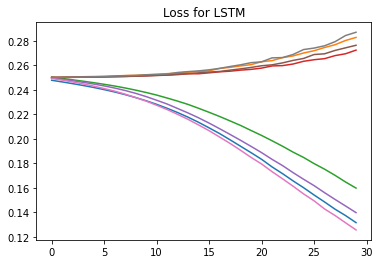

In [25]:
for i in range(NFOLD-1):
    loss = lstm_result[i]['loss']
    val_loss = lstm_result[i]['val_loss']
    plt.plot(loss)
    plt.plot(val_loss)
    plt.title('Loss for LSTM')

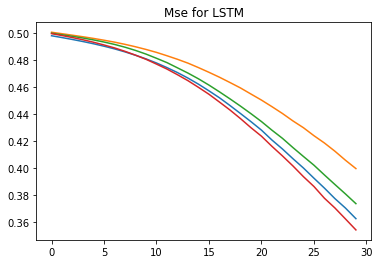

In [26]:
for i in range(NFOLD-1):
    mse = lstm_result[i]['root_mean_squared_error']
    plt.plot(mse)
    plt.title('Mse for LSTM')

26/26 [==============================] - 2s 8ms/step


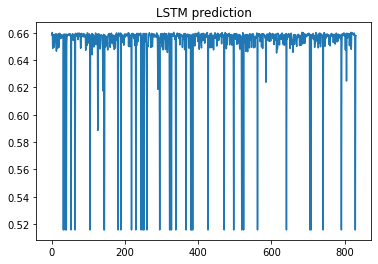

In [27]:
lstm_predict = lstm.predict(test_dataset, verbose = True)
plt.title("LSTM prediction")
plt.plot(lstm_predict)